<a href="https://colab.research.google.com/github/Yalnyra/Intel-Image-Dataset/blob/main/Vinokur_Practice_2_CVDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Фінальний проєкт
## Класифікація зображень за допомогою PyTorch

**Мета роботи: Навчитись тренувати базову нейронну мережу для класифікації зображень.**

**Вимоги:**
1. Препроцессинг, train/pred, тест повністю на розмічених зображеннях.


Аугментація, blur/grayscale/affine transform/noise

2.
Архітектура:

Пару CNN шарів, 2-3 Linear

3. Дифференційовний лосс  - бінарні BCE не підходять, візьмемо weighted CrossEntropy або в крайньому випадку дизбалансу AdaptiveLogSoftmax - для ймовірності.

Max/median pooling, batch norm
3. Lr_rate finetuning,


1. **1.-5. Створення DataLoader**, використаємо готовий класс torch

In [ ]:
# @title Для colab потрібно опціональні частини torch
%pip install torchvision

In [ ]:
# @title wandb
%pip install wandb

In [ ]:
# Image load

import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import torchvision
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from torch.optim import Adam, lr_scheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# import wandb


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
URL = "drive/MyDrive/Intel-Image-Classification"
folder = ['seg_pred/seg_pred', 'seg_train/seg_train', 'seg_test/seg_test']
BATCH_SIZE = 64
_NUM_WORKERS = os.cpu_count() // 2
_INPUT_SIZE = 150
SEED = 1234

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

Data Image loader

In [ ]:
rng = np.random.default_rng(seed=SEED)

In [ ]:
# @title loading image from Intel Image folder
# @markdown # Запишемо всі лейбли і шляхи до файлів, -1 відповідає за непомічені дані
class ImageDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, generator=rng):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.img_label_pairs = []
        self.classes = {}
        self.subdir = 'seg_train/seg_train' if train else 'seg_test/seg_test'

        # Collect all image paths and their corresponding labels
        subdir_path = os.path.join(root_dir, self.subdir)
        for class_name in os.listdir(subdir_path):
            class_path = os.path.join(subdir_path, class_name)
            if os.path.isdir(class_path):
                if class_name not in self.classes:
                    self.classes[class_name] = len(self.classes)
                for filename in os.listdir(class_path):
                    if filename.endswith('.jpg'):
                        self.img_label_pairs.append(
                            (os.path.join(class_path, filename),self.classes[class_name]))

        # # Collect images from seg_pred (unlabeled data)
        # unlabeled = os.path.join(root_dir, 'seg_pred/seg_pred')
        # for filename in os.listdir(unlabeled):
        #     if filename.endswith('.jpg'):
        #         self.img_label_pairs.append(
        #         (os.path.join(unlabeled, filename),-1)
        #         )

        rng.shuffle(self.img_label_pairs)



    @staticmethod
    def _to_tensor(image):
        return transforms.Compose([
            # transforms.ToImage(),
            # transforms.ToDtype(torch.float32, scale=True)
            transforms.ToTensor()
            ])(image)

    def __len__(self):
        return len(self.img_label_pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label = self.img_label_pairs[idx]
        print(label)
        image = ImageDataset._to_tensor(Image.open(img_path).convert('RGB'))
        label = torch.tensor(label, dtype=torch.int)

        if self.transform:
            image = self.transform(image)

        return image, label

# Example usage:
# Define any transformations you want to apply to the images
transform = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create the dataset
dataset = ImageDataset(root_dir=URL, transform=transform)

# Access an image tensor and its label
image_tensor, label = dataset[0]
print(image_tensor.shape, label)


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


4
torch.Size([3, 150, 150]) tensor(4, dtype=torch.int32)


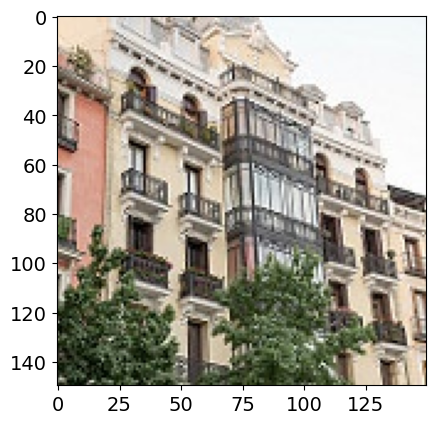

In [ ]:
 plt.imshow(np.transpose(image_tensor.numpy(), (1, 2, 0)))

In [ ]:
dataset.classes

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# @markdown this will be needed for loading images

In [ ]:
data_train = ImageDataset(URL, train=True)
data_test = ImageDataset(URL, train=False)

- Загальний розмір вибірки
- Розмір зображення
- Розмір класів

In [ ]:
data_train, data_valid = random_split(data_train, lengths=[0.8, 0.2])

In [ ]:
print(len(data_train),len( data_valid), len(data_test))

In [ ]:
data_test[3]

### Нормалізуємо дані

- міняємо (M, N, C) на (C, M, N)
- Переводимо у тензор


### Наші лоадери

In [ ]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

## Трансформації

- Випадкова деформація гамми - інваріантність від освітлення фотографії з інтернету
- Афінна трасформація - додаткова інваріантність по розміщенню об'єкта на фотографії

In [ ]:
train_transforms = transforms.Compose([
    transforms.Normalize(mean=)
    transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.01),
    transforms.Grayscale()
    transforms.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.85, 1.15), interpolation=transforms.InterpolationMode.BILINEAR)

])

test_transforms = ImageDataset._to_tensor

In [ ]:
advanced_transforms = transforms.Compose([
    # transforms.RandomChoice([
    #     transforms.RandomRotation(degrees=(-15, 15)),
    #     transforms.RandomRotation(degrees=(80, 100))
    # ]),
    transforms.Scale()
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
])

augmentations = transforms.Compose([
    transforms.GaussianNoise(sigma=0.12),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
])

In [ ]:
features_size = len(data_train)

In [ ]:
features_mean = torch.zeros(features_size)
features_squared_mean = torch.zeros(features_size)

for item, label in train_data:
    features_mean += torch.mean(features, [1, 2])
    features_squared_mean += torch.mean(features ** 2, [1, 2])

features_mean /= len(train_data)
features_squared_mean /= len(train_data)

features_std = torch.sqrt(features_squared_mean - features_mean ** 2)

In [ ]:
def normalize_sample(sample):
    m = len(features_mean) // 2
    sample["pre_fire"] = F.normalize(sample["pre_fire"], features_mean[:m], features_std[:m])
    sample["post_fire"] = F.normalize(sample["post_fire"], features_mean[m:], features_std[m:])
    return sample

Це не бінарна класифікація - потрібен softmax лосс або загалом місідентифікації, KL Divergence. Суму по Regression + CrossEntropy loss для замічених даних

In [ ]:
loader_train = WrappedDataLoader(DataLoader(data_train,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=_NUM_WORKERS), to_device)
loader_eval = WrappedDataLoader(DataLoader(data_valid,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            num_workers=_NUM_WORKERS), to_device)
loader_test = WrappedDataLoader(DataLoader(data_test,
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,
                                            num_workers=_NUM_WORKERS), to_device)

In [ ]:
print("Training examples : ", len(loader_train))

print("Validation examples : ", len(loader_eval))
print("Testing examples : ", len(loader_test))
print("Total train classes : ", len(set(data_test.classes)))
print("Total test classes : ", len(set(data_test.classes)))

In [ ]:
def draw_images_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array)-1)
        image = image_array[index]
        plt.axis('off')
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

In [ ]:
batch_iter_train = iter(loader_train)
batch_iter_eval = iter(loader_eval)
batch_iter_test = iter(loader_test)

In [ ]:
X_train, y_train = next(batch_iter_train)
# X_eval, y_eval = next(batch_iter_eval)
X_test, y_test = next(batch_iter_test)


In [ ]:
X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

In [ ]:
X_train.shape

In [ ]:
X_test.shape

- Кожне зображення має формат [B,C,H,W] - [32, 3, 32, 32]

In [ ]:
def calculate_histogram(image: np.ndarray):
    """
    Calculate histogram for each color channel of the image.

    Args:
        image (tensor): Image np of shape [H, W, C].

    Returns:
        hist (tensor): Histogram tensor of shape [C].
    """
    hist = np.zeros(image.shape[0])
    for c in range(image.shape[0]):
        hist[c] = np.mean(np.array(image[c,:,:]))
    return hist
def mean_color_histogram(batch):
    """
    Compute the mean color histogram for a batch of images.

    Args:
        batch (tensor): Batch of images of shape [B, C, H, W]

    Returns:
        mean_hist (tensor): Mean histogram tensor of shape [B, C].
    """

    # batch_size, channels, height, width = batch.size()
    #batch_size = batch.shape[0]
    batch_size = BATCH_SIZE
    histograms = np.zeros((batch_size, 3))

    for i in range(batch_size):
        histograms[i] = calculate_histogram(batch[i])

    print(histograms.shape)
    #mean_hist = histograms.partition(histograms, axis=0, kind='mergesort')
    return histograms
# Example batch of images with random values and specified size [batch_size, channels, height, width]

# Generate random images (for demonstration)
# batch = torch.rand((batch_size, channels, height, width))

# Calculate mean color histogram
#bins = 100
# mean_hist = mean_color_histogram(batch, bins=bins)

# Plot the mean color histogram
def plot_histogram(histogram, bins, channels=3):
    colors = ['r', 'g', 'b']
    bin_edges = np.linspace(0, 1, 65)

    plt.figure(figsize=(10, 4))
    for c in range(channels):
        #plt.plot(bin_edges[:-1], histogram[:, c], color=colors[c], alpha=0.5)
        #plt.plot(bin_edges[:-1], histogram[c].numpy(), alpha=0.5)
        plt.hist(histogram[:, c], bins=bins, color=colors[c], alpha=0.5)


    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Mean Color Histogram')
    plt.legend(['Red', 'Green', 'Blue'])
    plt.show()

In [ ]:
plt.rcParams.update({'font.size': 14})

# Train class distribution
plt.figure(figsize=(12,6))
plt.hist(y_train, len(set(y_train)))
plt.xlabel('Class number')
plt.ylabel('Amount of samples')
plt.title('Training sample class distribution')

# # Validation class distribution
# plt.figure(figsize=(12,6))
# plt.hist(y_valid, len(set(y_valid)))
# plt.xlabel('Class number')
# plt.ylabel('Amount of samples')
# plt.title('Validation sample class distribution')

# Test class distribution
plt.figure(figsize=(12,6))
plt.hist(y_test, len(set(y_test)))
plt.xlabel('Class number')
plt.ylabel('Amount of samples')
plt.title('Testing sample class distribution')

draw_images_examples(X_train, 5, 3, 'Examples of images from training set')
mean_colors = mean_color_histogram(X_train)
plot_histogram(mean_colors, bins=20)

example_class = y_train[random.choice(data_train.classes)]
# example_class = y_train[-1]
X_train_one_label = X_train[np.where(y_train==data_train.classes['glacier'])]

draw_images_examples(X_train_one_label, 5, int(example_class), f'Examples of images of the class - {[int(example_class)]}')
plt.show()

In [ ]:
draw_images_examples(X_test, 5, 3, 'Examples of images from test set')
mean_colors = mean_color_histogram(X_test)
plot_histogram(mean_colors, bins=20)

example_class = y_test[random.randint(0, len(y_test))]
X_test_one_label = X_test[np.where(y_train==example_class)]

draw_images_examples(X_test_one_label, 5, 3, f'Examples of images of the class - {int(example_class)}')
plt.show()

In [ ]:
example_class = y_train[random.choice(data_train.classes)]
# example_class = y_train[-1]
X_train_one_label = X_train[np.where(y_train==data_train.classes['glacier'])]

draw_images_examples(X_train_one_label, 5, int(example_class), f'Examples of images of the class - {[int(example_class)]}')
plt.show()

In [ ]:
import seaborn as sns
from sklearn.cross_decomposition import PLSCanonical

In [ ]:

from sklearn.manifold import Isomap
from sklearn.linear_model import LogisticRegression

iso = Isomap(n_components=4)

iso.fit(X_train[0,0,:,:])

X_train_iso = iso.transform(X_train[0,0,:,:])
X_test_iso = iso.transform(X_test[0,0,:,:])

iso_model = LogisticRegression()

start = time.time()

iso_model.fit(X_train_iso, y_train)
iso_model_score = iso_model.score(X_test_iso, y_test)